# Import the required packages

In [58]:
import time  
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import pandas as pd
import glob
from scipy import stats

import PIL
import PIL.Image as Image

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score

In [59]:
import keras
import keras.preprocessing.image as im
import keras.datasets as datasets
import keras.layers as layers
import keras.losses as losses
import keras.regularizers as rg
from keras.models import Model
from keras.models import Sequential
from keras import backend as K

# Raw Data

About the data: <br>
1) In total: 2x35=70 samples <br>
2) For each sample, there are 7 different I-V data for conductance measurement taken at different location (70x7=490) <br>
3) For each sample, there are 3 images for spin-coated Spiro-OMeTAD layer after annealing (70x3=210), taken from different areas of the sample. All the original image files are of the size (4000, 3000) for width and height, respectively

# of conductivity files: 490

# of conductivity measurement observations: 490



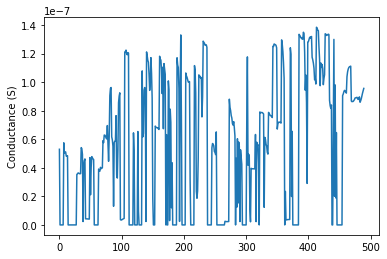

In [60]:
data_dir = os.getcwd()+r'\ada-master'

# load and visualize all the conductivity data from CSV files

cFiles = glob.glob(data_dir+r'\**\**\**\*annealing.csv', recursive = False) 
print("# of conductivity files: "+str(len(cFiles))+"\n")

cond_orig = []  # to store the original conductance measurement data
for cFile in cFiles:
    ivData = pd.read_csv(cFile)
    curr = ivData.Current.values
    vol = ivData.Voltage.values
    temp,_,_,_,_ = stats.linregress(vol,curr)  # conductance in S
    cond_orig.append(temp)
    
print("# of conductivity measurement observations: "+str(len(cond_orig))+"\n")

plt.figure()
plt.plot(cond_orig)
plt.ylabel('Conductance (S)')
plt.show()


# of DF image files: 210

# of DF image data: 210

Type of the image data using MPL: 
<class 'numpy.ndarray'>
(3000, 4000, 3)


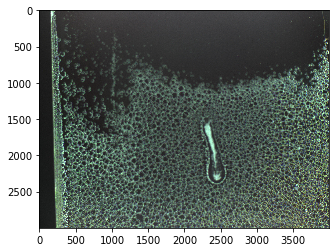

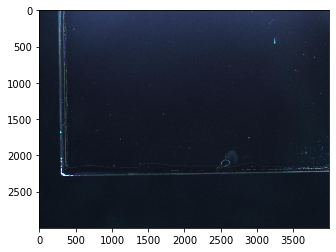

In [61]:
# load all the DF image data from the jpeg files
imFiles = glob.glob(data_dir+r'\**\**\*annealing*.jpg', recursive = False) 
print("# of DF image files: "+str(len(imFiles))+"\n")

dfImgs = []  # store all the image data as PIL images
for imFileNum,imFile in enumerate(imFiles):
    img = Image.open(imFile)
    img = img.resize((200,150))
    dfImgs.append(img)

print("# of DF image data: "+str(len(dfImgs))+"\n")
#dfImgs[0].show()

img = mpimg.imread(imFiles[0])   # import the image data as numpy array
plt.figure()
plt.imshow(img)
img = mpimg.imread(imFiles[-1])
plt.figure()
plt.imshow(img)

print("Type of the image data using MPL: ")
print(type(img))
print(img.shape)   # size 3000x4000x3


# Data Preprocessing
    
1) For each sample, average the 7 different conductance data for labeling <br>
2) Duplicate each conductance data point twice, so they align with the image data <br>
3) Normalize the conductance data <br>
4) Convert the PIL image instances into numpy array <br>
5) Split the data into train and test sets

# of averaged conductivity observations: 70



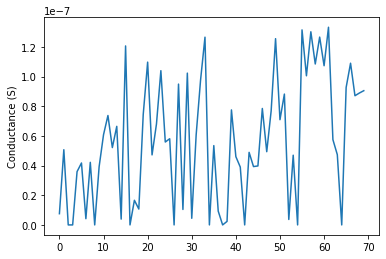

# of finalized conductivity labels: 
(210, 1)


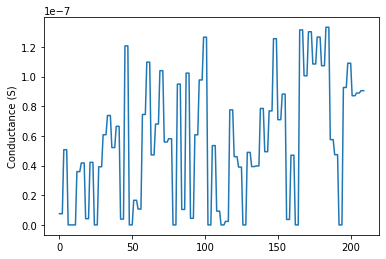

In [62]:
# For each sample, average the 7 different conductance data for labeling
cond = []
tmp = 0
for i in range(len(cond_orig)):
    tmp = tmp+cond_orig[i]
    if (i%7)==6:
        cond.append(tmp/7)  # take the average
        tmp = 0

print("# of averaged conductivity observations: "+str(len(cond))+"\n")
plt.figure()
plt.plot(cond)
plt.ylabel('Conductance (S)')
plt.show()


# Duplicate each data point twice, so they align with the 3 images for a given sample
cond_final = []
for x in cond:
    cond_final.append(x)
    cond_final.append(x)
    cond_final.append(x)

cond_final = np.array(cond_final)
cond_final = np.reshape(cond_final,(-1,1))  # reshape it for the training
    
print("# of finalized conductivity labels: ")
print(cond_final.shape)
plt.figure()
plt.plot(cond_final)
plt.ylabel('Conductance (S)')
plt.show()

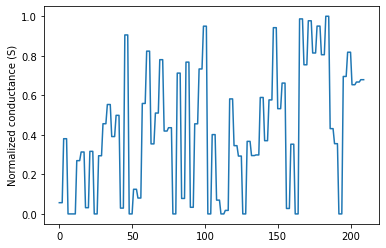

In [63]:
# Normalize the conductance data
scaler = MinMaxScaler()
cond_final = scaler.fit_transform(cond_final)
plt.figure()
plt.plot(cond_final)
plt.ylabel('Normalized conductance (S)')
plt.show()

In [64]:
# Convert the PIL image instances into numpy array
input_arr = []
for x in dfImgs:
    input_arr.append(im.img_to_array(x))


input_arr = np.array(input_arr)
print(input_arr.shape)

(210, 150, 200, 3)


Training image data size: 
(134, 150, 200, 3)
Training conductance data size: 
(134, 1)
Test image data size: 
(42, 150, 200, 3)
Test conductance data size: 
(42, 1)
Validation image data size: 
(34, 150, 200, 3)
Validation conductance data size: 
(34, 1)


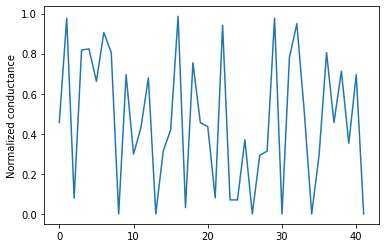

In [65]:
# split the data
trainX_i, testX, trainY_i, testY = train_test_split(input_arr, cond_final, test_size=0.20, random_state=42, shuffle=True)
trainX, valX, trainY, valY = train_test_split(trainX_i, trainY_i, test_size=0.20, random_state=42, shuffle=True)
print("Training image data size: ")
print(trainX.shape)
print("Training conductance data size: ")
print(trainY.shape)
print("Test image data size: ")
print(testX.shape)
print("Test conductance data size: ")
print(testY.shape)
print("Validation image data size: ")
print(valX.shape)
print("Validation conductance data size: ")
print(valY.shape)

plt.figure()
plt.plot(testY)
plt.ylabel('Normalized conductance')
plt.show()

# Train and evaluate the CNN
    
1) Construct the CNN layers <br>
2) Augment image data <br>
3) Train the CNN model <br>
4) Evaluate the model using test data

In [66]:
# Define the CNN network structure
model = Sequential()

#model.add(layers.Conv2D(32,(3,3),activation='relu', input_shape=(150, 200, 3)))
model.add(layers.Conv2D(32, (3,3), activation='relu', kernel_regularizer=rg.l2(), input_shape=(150, 200, 3)))
#model.add(layers.BatchNormalization(axis=-1))
model.add(layers.MaxPooling2D((2,2)))
#model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.Conv2D(64, (3,3), activation='relu', kernel_regularizer=rg.l2()))
#model.add(layers.BatchNormalization(axis=-1))
model.add(layers.MaxPooling2D((2,2)))
#model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.Conv2D(64, (3,3), activation='relu', kernel_regularizer=rg.l2()))
#model.add(layers.BatchNormalization(axis=-1))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1))
     
optimizer = keras.optimizers.Adam(learning_rate=0.001)
loss = losses.MeanSquaredError()
metrics = keras.metrics.RootMeanSquaredError()

model.compile(optimizer=optimizer,loss=loss, metrics=[metrics])
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 198, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 99, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 97, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 48, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 46, 64)        36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 23, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 25024)            

In [67]:
# Augment the input images

datagen = im.ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0)

In [282]:
# Train CNN
EPOCHS = 200
BATCH_SIZE=32

history = model.fit(datagen.flow(trainX, trainY, batch_size=BATCH_SIZE),
          steps_per_epoch=len(trainX)/BATCH_SIZE, epochs=EPOCHS,
          validation_steps=len(trainX)/BATCH_SIZE,
          validation_data=datagen.flow(valX, valY, batch_size=BATCH_SIZE),verbose=True)

Epoch 1/200
5/4 [===================================] - 4s 821ms/step - loss: 0.0541 - root_mean_squared_error: 0.2088 - val_loss: 0.0764 - val_root_mean_squared_error: 0.2411
Epoch 2/200
5/4 [===================================] - 3s 692ms/step - loss: 0.0385 - root_mean_squared_error: 0.1906 - val_loss: 0.0156 - val_root_mean_squared_error: 0.2151
Epoch 3/200
5/4 [===================================] - 4s 767ms/step - loss: 0.0428 - root_mean_squared_error: 0.1832 - val_loss: 0.0465 - val_root_mean_squared_error: 0.2021
Epoch 4/200
5/4 [===================================] - 4s 703ms/step - loss: 0.0350 - root_mean_squared_error: 0.1717 - val_loss: 0.0443 - val_root_mean_squared_error: 0.2533
Epoch 5/200
5/4 [===================================] - 4s 727ms/step - loss: 0.0454 - root_mean_squared_error: 0.1892 - val_loss: 0.0538 - val_root_mean_squared_error: 0.1989
Epoch 6/200
5/4 [===================================] - 4s 709ms/step - loss: 0.0440 - root_mean_squared_error: 0.1869 -

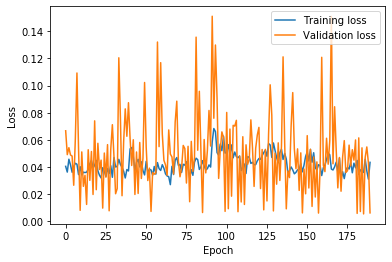

In [283]:
# visualize the training process
plt.figure()
plt.plot(history.history['loss'][10:], label='loss')
plt.plot(history.history['val_loss'][10:], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training loss','Validation loss'])
plt.show()

In [284]:
# evaluate the CNN model using RMSE
performance = model.evaluate(datagen.flow(testX, testY, batch_size=BATCH_SIZE))
RMSE = performance[1]
print(print("The absolute RMSE is: "))
print(RMSE)

2/2 [==============================] - 0s 203ms/step
The absulute RMSE os: 
None
0.19358493387699127


The normalized RMSE os: 
[0.21227493]


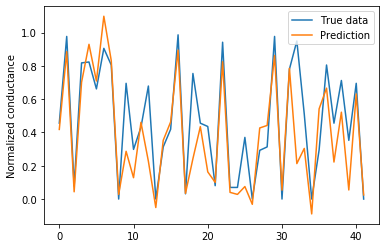

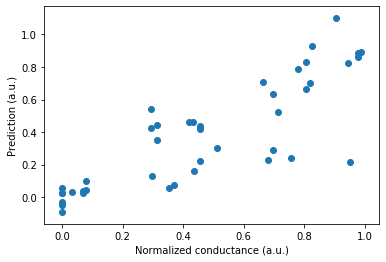

In [285]:
def NRMSE(yhat, y):
    num = np.sqrt(np.mean((yhat.flatten() - y.flatten())**2))
    den = max(y) - min(y)
    return num / den


# Visualize the predicted data
predY = model.predict(testX)
print("The normalized RMSE is: ")
print(NRMSE(predY, testY))

plt.figure()
x_true = np.arange(len(testY))
x_pred = np.arange(len(predY))
plt.plot(x_true,testY,x_pred,predY)
plt.ylabel('Normalized conductance')
plt.legend(['True data','Prediction'])
plt.show()

plt.figure()
plt.scatter(testY,predY)
plt.xlabel('Normalized conductance (a.u.)')
plt.ylabel('Prediction (a.u.)')
plt.show()


df = pd.DataFrame({'Normalized conductance':testY.flatten(),'Prediction':predY.flatten()})
writer = pd.ExcelWriter('CNN_results.xlsx',engine='xlsxwriter')
df.to_excel(writer,'Sheet1',index=False)
writer.save()


#### Training process analysis:

1) How the gradients vary accross layers <br>
2) How the activations vary accross layers

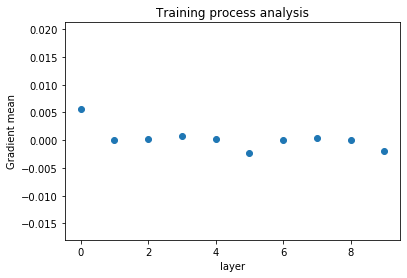

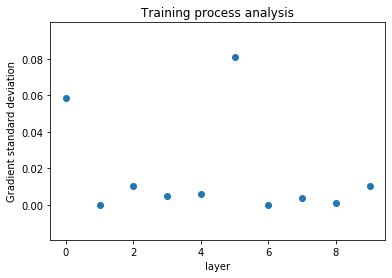

In [286]:
# Analyze the gradients for each layer during the training
def get_weight_grad(model, data, labels):
  
    means = []
    stds = []

    grads = model.optimizer.get_gradients(model.total_loss, model.trainable_weights)
    symb_inputs = (model._feed_inputs + model._feed_targets + model._feed_sample_weights)
    f = K.function(symb_inputs, grads)
    x, y, sample_weight = model._standardize_user_data(data, labels)
    output_grad = f(x + y + sample_weight)
    
    for layer in range(len(model.layers)):
        #if model.layers[layer].__class__.__name__ == 'Conv2D':
        means.append(output_grad[layer].mean())
        stds.append(output_grad[layer].std())
        
    return means, stds



lys = range(len(model.layers))
means, stds = get_weight_grad(model, trainX, trainY)

plt.figure()
#plt.plot(means)
plt.scatter(lys,means)
plt.xlabel('layer')
plt.ylabel('Gradient mean')
plt.title('Training process analysis')
plt.show()

plt.figure()
#plt.plot(stds)
plt.scatter(lys,stds)
plt.xlabel('layer')
plt.ylabel('Gradient standard deviation')
plt.title('Training process analysis')
plt.show()

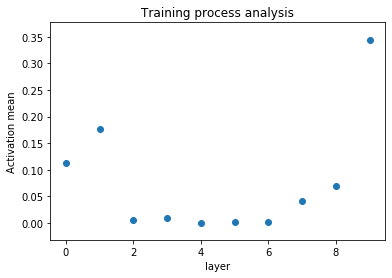

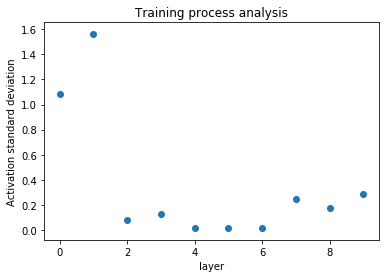

In [287]:
# Analyze the activations for each layer during the training
def get_stats(model, data):
  means = []
  stds = []
  
  for layer in range(len(model.layers)):
    #if model.layers[layer].__class__.__name__ == 'Conv2D':
      m = Model(model.input, model.layers[layer].output)
      pred = m.predict(data)
      means.append(pred.mean())
      stds.append(pred.std())
    
  return means, stds



lys = range(len(model.layers))
means, stds = get_stats(model, trainX)

plt.figure()
#plt.plot(means)
plt.scatter(lys,means)
plt.xlabel('layer')
plt.ylabel('Activation mean')
plt.title('Training process analysis')
plt.show()

plt.figure()
#plt.plot(stds)
plt.scatter(lys,stds)
plt.xlabel('layer')
plt.ylabel('Activation standard deviation')
plt.title('Training process analysis')
plt.show()